# Результаты A-B теста

В данном задании буду изучать АБ тест, проведенный на реальных пользователях Яндекса.

### Описание данных:

* `userID` — уникальный идентификатор пользователя
* `browser` — браузер, который использовал userID
* `slot` — в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* `n_clicks` — количество кликов, которые пользоваль совершил за n_queries
* `n_queries` — количество запросов, который совершил userID, пользуясь браузером browser
* `n_nonclk_queries` — количество запросов пользователя, в которых им не было совершено ни одного клика


In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv('data/ab_browser_test.csv',sep=',')

df['click_per_queries'] = df['n_clicks']/df['n_queries']
df['empty_query_share'] = df['n_nonclk_queries']/df['n_queries']

print(df.shape)
df.head()

(566134, 8)


,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
0,1,Browser #2,exp,23,32,19,0.718750,0.593750
1,3,Browser #4,exp,3,4,2,0.750000,0.500000
2,5,Browser #4,exp,29,35,16,0.828571,0.457143
3,6,Browser #4,control,12,6,0,2.000000,0.000000
4,7,Browser #4,exp,54,68,30,0.794118,0.441176


Будем работать с числом кликов на количество пользовательских сессий. 

> Вообще, это ratio-метрика. Из-за этого у неё будут довольно тяжёлые хвосты. Мы увидим это ниже в пункте про бутстрэп. И к ней нужен особый подход. Пока что будем это игнорировать. В целом, можно откатиться к кликам и работать с их средним, но методологически правильнее отнормировать их на число сессий.

Насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе:

In [3]:
exp = df.loc[df['slot'] == 'exp', 'n_clicks'].sum() 
control = df.loc[df['slot'] == 'control', 'n_clicks'].sum()
print(f"Число кликов у экспериментальной группы на {(exp-control)/control * 100:.2f}% больше, чем у контрольной")

# дальшеработать буду с этим
exp = df.loc[df['slot'] == 'exp', 'click_per_queries']
control = df.loc[df['slot'] == 'control', 'click_per_queries']
print(f"Число кликов на кол-во пользовательских сессий у экспериментальной группы на {(exp.sum()-control.sum())/control.sum() * 100:.2f}% больше, чем у контрольной")


Число кликов у экспериментальной группы на 1.61% больше, чем у контрольной
Число кликов на кол-во пользовательских сессий у экспериментальной группы на 6.37% больше, чем у контрольной


Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

## Часть 1: анализ АБ-теста

Посмотрим на клики в наших пользовательских сессиях. 

**Ответы:**

- Выбросы есть, видно по boxplot и длинному хвосту на гистограмме
- Похоже, что полученные выборки пришли из одного распределения, т.к. гистограммы распределений очень похожи. Квантили распределения имеют похожие границы, при этом по медиане (50% персентиле) виден сдвиг у экспериментальной группы в сравнении с контрольной
- Какие тесты можно использовать - точно непараметрические, чтобы не делать спорных предположений о виде распределения (Манна-Уитни, т.к. распределения похожи и можно проверить сдвиг, Уилкоксона). Возможно параметрические тесты можно попробовать, но точно нужно делать предобработку данных (смотреть на влияние выбросов, возможно данные стандартизировать, проводить какие-либо действия с ними) 

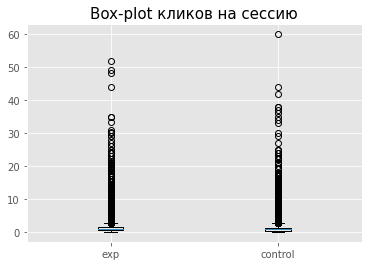

In [4]:
plt.boxplot([exp, control], labels=['exp', 'control'])
plt.title('Box-plot кликов на сессию', size=15);

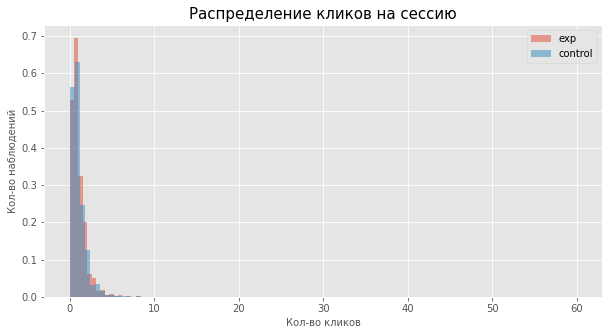

In [5]:
plt.figure(figsize=(10, 5))
plt.hist(exp, density=True, bins=100, alpha=0.5, label='exp')
plt.hist(control, density=True, bins=100, alpha=0.5, label='control')
plt.title('Распределение кликов на сессию', size=15)
plt.xlabel('Кол-во кликов', size=10)
plt.ylabel('Кол-во наблюдений', size=10)
plt.legend();

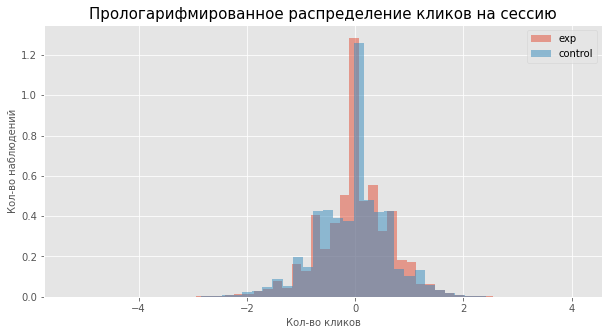

In [6]:
plt.figure(figsize=(10, 5))
plt.hist(exp[exp > 0].apply(lambda x: np.log(x)), density=True, bins=50, alpha=0.5, label='exp')
plt.hist(control[control > 0].apply(lambda x: np.log(x)), density=True, bins=50, alpha=0.5, label='control')
plt.title('Прологарифмированное распределение кликов на сессию', size=15)
plt.xlabel('Кол-во кликов', size=10)
plt.ylabel('Кол-во наблюдений', size=10)
plt.legend();

In [7]:
exp_quantiles = []
control_quantiles = []

for i in np.arange(0.1, 1.1, 0.1):
    exp_quantiles.append(exp.quantile(i))
    control_quantiles.append(control.quantile(i))
    
for i in range(len(exp_quantiles)):
    print(f"{i+1}-й квантиль - exp: {exp_quantiles[i]:.4f}, control: {control_quantiles[i]:.4f}")

1-й квантиль - exp: 0.0000, control: 0.0000
2-й квантиль - exp: 0.4000, control: 0.3000
3-й квантиль - exp: 0.6000, control: 0.5000
4-й квантиль - exp: 0.8000, control: 0.7059
5-й квантиль - exp: 1.0000, control: 0.9231
6-й квантиль - exp: 1.0000, control: 1.0000
7-й квантиль - exp: 1.2353, control: 1.1429
8-й квантиль - exp: 1.5238, control: 1.5000
9-й квантиль - exp: 2.0000, control: 2.0000
10-й квантиль - exp: 52.0000, control: 60.0000


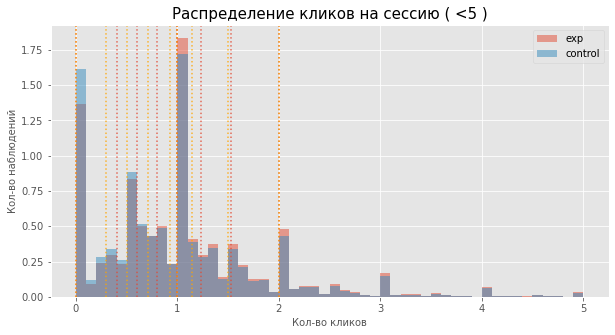

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(exp[exp <= 5], density=True, bins=50, alpha=0.5, label='exp')
plt.hist(control[control <= 5], density=True, bins=50, alpha=0.5, label='control')
plt.title('Распределение кликов на сессию ( <5 )', size=15)
plt.xlabel('Кол-во кликов', size=10)
plt.ylabel('Кол-во наблюдений', size=10)
for line in exp_quantiles[:-1]:
    plt.axvline(line, alpha=0.8, ls='dotted')
for line in control_quantiles[:-1]:
    plt.axvline(line, alpha=0.8, color='orange', ls='dotted')

plt.legend();

$z$-тест нам не подходит из-за выбросов. Однако, мы не можем наверняка знать, насколько серьёзное влияние эти выбросы оказали на ЦПТ и сломали ли они её. Если посчитать по выброкам средние и медианы, они окажутся очень похожими.

Проведем бутстрап на контрольной группе, т.к. мы не знаем истинного распределения генеральной совокупности. Поймем, как распределена z-статистика и сравним её распределение с нормальным. 

Поскольку мы знаем, что $\text{Var}(\bar X_n) = \frac{\sigma^2}{n}$, нам не надо будет делать бутстрэп в бутстрэпе.

1. Получаем из данных `n_boot_samples` псевдовыборок,
2. По каждой из этих выборок посчитаем среднее и его дисперсию,
3. Рассчитаем значение $z$-статистики,
4. Для получившегося вектора из $z$-статистик построим `qq-plot` с помощью ` scipy.stats.probplot` для нормального распределения.


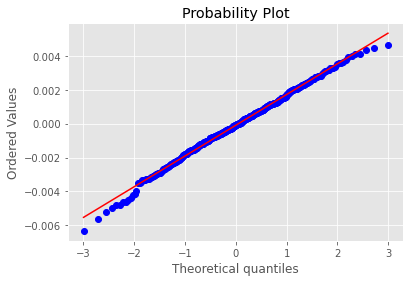

In [9]:
n_boot_samples = 500

def get_bootstrap_sample(x, B=1):
    N = x.size
    sample = np.random.choice(x, size=(N, B), replace=True)
    if B == 1:
        sample = sample.T[0]
    return sample

boot_samples = get_bootstrap_sample(control, B=n_boot_samples)

boot_samples_mean = np.mean(boot_samples, axis=0)
boot_samples_var = np.var(boot_samples, axis=0)

z_stats = (boot_samples_mean - control.mean()) / np.sqrt(boot_samples_var)
sts.probplot(z_stats, plot=plt);

*Получилось распределение с хвостами более тяжелыми, чем у нормального распределения. Вероятно, выбросы продолжают оказывать свое влияние и, попадая в бутстрапированные выборки, немного отклоняют распределение от нормального*

Не очень хорошо, но все-таки ради интереса проверим гипотезу о равенстве средних между группами с помощью $z-$теста на уровне значимости $1\%$.

Гипотеза:

$H_0: \mu_{exp} - \mu_{control} = 0$

$H_a: \mu_{exp} - \mu_{control} \neq 0$



In [10]:
alpha = 0.01
mean_control = control.mean()
mean_exp = exp.mean()
var_control = control.var(ddof=1)
var_exp = exp.var(ddof=1)

z_obs = (mean_exp - mean_control - 0) / np.sqrt((var_control / control.size) + (var_exp / exp.size))

z_crit = sts.norm.ppf(1 - alpha)
pval = 2 * (1 - sts.norm().cdf(np.abs(z_obs)))

print(f'''Наблюдаемое значение {z_obs:.2f} больше критического {z_crit:.2f} (эквивалентно: p-value = {pval:.2f} < 0.01) => 
=> нулевая гипотеза отвергается на 1% уровне значимости''')


Наблюдаемое значение 27.56 больше критического 2.33 (эквивалентно: p-value = 0.00 < 0.01) => 
=> нулевая гипотеза отвергается на 1% уровне значимости


In [11]:
# На всякий - проверка себя через statsmodels
from statsmodels.stats.weightstats import ztest

print(f'''Наблюдаемое значение {ztest(exp, control)[0]:.2f} больше критического {z_crit:.2f} (эквивалентно: p-value = {ztest(exp, control)[1]:.2f} < 0.01) => 
=> нулевая гипотеза отвергается на 1% уровне значимости''')

Наблюдаемое значение 27.56 больше критического 2.33 (эквивалентно: p-value = 0.00 < 0.01) => 
=> нулевая гипотеза отвергается на 1% уровне значимости


Попробуем понять, какими при таких объёмах выборки оказываются MDE и ошибка второго рода. Конечно, же сделать это надо до проведения АБ-теста. Но мы анализируем АБ-тест, а не готовим его! 

Формула для расчета числа наблюдений __для одной группы:__

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

In [12]:
MDE = 0.01

def get_beta(n, MDE, var_a, var_b, alpha):
    za = sts.norm.ppf(1 - alpha / 2)
    zb = MDE * np.sqrt(n / (var_a + var_b)) - za
    return 1 - sts.norm.cdf(zb)

beta_exp = get_beta(exp.size, MDE, var_control, var_exp, alpha)
beta_control = get_beta(control.size, MDE, var_control, var_exp, alpha)
print(f"exp_beta = {beta_exp:.4f}")
print(f"control_beta = {beta_control:.4f}")
print(f"total beta = {beta_exp + beta_control:.4f}")

exp_beta = 0.1424
control_beta = 0.1381
total beta = 0.2805


 Хвосты отличаются от стандартного нормального. По хорошему, для проверки гипотезы нужно использовать бутстрап. В контексте средних, на бутстрап можно смотреть как на технику, которая уточняет, насколько сильно хвосты распределения стали тяжелее по сравнению с ЦПТ. 

Проверим гипотезу с помощью бутстрапа!

1. Посчитаем наблюдаемое значение статистики.
2. Пусть $\bar h$ - это среднее посчитанное по обеим выборкам вместе. Создаем две новые выборки $$x'_i = x_i - \bar x + \bar h \\ y'_i = y_i - \bar y + \bar h.$$ Такое рецентрирование сдвигает обе выборки к общему среднему и  позволит заложить в симуляцию информацию о верности нулевой гипотезы. 
3. Сбутстрапируйте выборки $x^{*}$ и $y^{*}$ из $x'$ и $y'$. Рассчитаем значение z-статистики. Повторим процедуру $B$ раз.
4. Для оценки `p-value` воспользуемся формулой:

$$
\frac{1}{B} \sum_{i=1}^B [z_i^{*} \ge z_{obs}]
$$

In [13]:
h_mean = np.append(control, exp).mean()
exp_shift = exp - mean_exp + h_mean
control_shift = control - mean_control + h_mean
exp_shift_mean = exp_shift.mean()
exp_shift_var = exp_shift.var()
control_shift_mean = control_shift.mean()
control_shift_var = control_shift.var()

# бутстрап из x' и y'
B = 1000
exp_boot = get_bootstrap_sample(exp_shift, B)
control_boot = get_bootstrap_sample(control_shift, B)

exp_boot_mean = np.mean(exp_boot, axis=0)
control_boot_mean = np.mean(control_boot, axis=0)
exp_boot_var = np.var(exp_boot, axis=0)
control_boot_var = np.var(control_boot, axis=0)

z_stats = (exp_boot_mean - control_boot_mean - 0) / \
            np.sqrt((exp_boot_var / exp.size) + (control_boot_var / control.size))
# z_obs = считал выше

pval = (z_stats >= z_obs).sum() / B
print(f"pvalue = {pval}")

pvalue = 0.0


In [14]:
print(f"критическое значение норм. расп.: {z_crit:.4f}") 
print(f"критическое значения бутстреп-статистики: {pd.Series(z_stats).quantile(1 - alpha):.4f}")

критическое значение норм. расп.: 2.3263
критическое значения бутстреп-статистики: 2.1617


 - Выводы АБ-теста изменились. Теперь мы не отвергаем нулевую гипотезу о равенстве средних между контролем и экспериментом, хотя z-тест показал, что разница между ними есть.
 - Заметим, что чаще будет совершатся ошибка 1-го рода, т.к. в критической области распределения (в хвостах) вероятностная масса будет больше, а значит вероятность того, что нам попадется экстремальное значение также больше. Хвосты норм. расп-я меньше, а значит мы недооцениваем вероятность появления экстремальных значений и чаще отвергаем нулевую гипотезу в пользу альтернативной. Эта ошибка будет возникать настолько чаще, насколько критическая область распределения с хвостами больше критической области нормального распределения на одинаковом уровне значимости alpha. 

Насколько больше наблюдений нам необходимо для проверки гипотезы по сравнению с z-тестом? 


$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

In [15]:
z_boot = pd.Series(z_stats).quantile(1 - alpha)

def get_n_obs(MDE, var_a, var_b, z_boot, beta):
    zb = sts.norm.ppf(1 - beta)
    n = (var_a + var_b) * ((z_boot + zb) ** 2) / (MDE ** 2)
    return round(n)

n_exp_boot = get_n_obs(MDE, var_control, var_exp, z_boot, beta_exp)
n_control_boot = get_n_obs(MDE, var_control, var_exp, z_boot, beta_control)

n_exp_z = get_n_obs(MDE, var_control, var_exp, sts.norm.ppf(1 - alpha / 2), beta_exp)
n_control_z = get_n_obs(MDE, var_control, var_exp, sts.norm.ppf(1 - alpha / 2), beta_control)


print(f'Число наблюдений для проверки гипотезы бутстрапом: {n_exp_boot + n_control_boot}')
print(f'Число наблюдений для z-теста: {n_exp_z + n_control_z}')

Число наблюдений для проверки гипотезы бутстрапом: 445105
Число наблюдений для z-теста: 566134


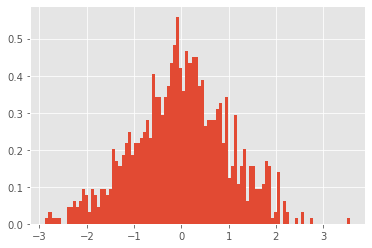

In [16]:
pd.Series(z_stats).hist(bins=100, density=True);

*Получилось, что наблюдений для бутстрапа нужно меньше. Если посмотреть на распределение получившихся оценок, то видно, что распределение немного скошено - правый хвост (т.е. квантиль, который мы смотрим) меньше и больше сдвинут внутрь основного распределения, а не вне*

Проверим гипотезу тестом Манна-Уитни. Используем для этого функцию `scipy.stats.mannwhitneyu`.

In [17]:
u, pval_mw = sts.mannwhitneyu(control, exp)

print(f"наблюдаемое значение статистики Манна-Уитни: {u:.2f}")
print(f"p-value критерия Манна-Уитни: {pval_mw:.2f}")

наблюдаемое значение статистики Манна-Уитни: 37765830709.50
p-value критерия Манна-Уитни: 0.00


*p-value < 0 => принимаем альтернативную гипотезу о наличии сдвига между 2мя одинаковыми распределениями контрольной и экспериментальной групп*

Вместо теста Манна-Уитни на сдвиг распределения, мы можем попробовать проверить гипотезу о том, что наше распределение, в принципе, как-то поменялось. Для таких гипотез обычно используются критерии согласия. Проверим гипотезу о том, что распределения тестовой и контрольной групп совпадают с помощью теста Колмогорова-Смирнова `scipy.stats.ks_2sam`.

In [18]:
ks_val, pval_ks = sts.ks_2samp(exp, control)

print(f'''p-value = {pval_ks:.2f} < 0.01) => нулевая гипотеза отвергается на 1% уровне значимости''')
print("Делаем вывод, что выборки теста и контроля не однородны")

p-value = 0.00 < 0.01) => нулевая гипотеза отвергается на 1% уровне значимости
Делаем вывод, что выборки теста и контроля не однородны


P-value большинства проводимых тестов (кроме бутстрэпа) близки к нулю. Наблюдаемое значение статистик значительно привосходит критическое, т.е. с лихвой попадает в критическую область. Возможно, по тестам становится понятно, что распределения контроля и теста сильно различаются и ставить гипотезы о параметрах этих распределений нужно тщательно и аккуратно (например, смотреть на прочие параметры медианы, хвосты, избавиться все-таки от выбросов, добивать однородности распределений). В общем, надо подумать (над метриками, гипотезами, тестах) и что-то сделать с данными, перед тем, как делать AB-тесты.

## Часть 2: CUPED

Рассчитаем значение стандартной ошибки для $z$-статистики по второй части выборки. С помощью CUPED мы будем пытаться уменьшить значение этой ошибки.

In [19]:
df['treat'] = np.where(df['slot'] == 'exp', 1, 0)
df_before = df.iloc[:len(df) // 2, :]
df_after = df.iloc[len(df) // 2:, :]
tr = df_after.loc[df_after['treat'] == 1, 'click_per_queries']
cntrl = df_after.loc[df_after['treat'] == 0, 'click_per_queries']

z_val = (tr.mean() - cntrl.mean()) / np.sqrt((tr.var() / tr.size) + (cntrl.var() / cntrl.size))


*Как понимаю, нужно смотреть на $se(\bar{y}_{treat} - \bar{y}_{control})$, т.е. на знаменатель при расчете z-статистики*

*Поэтому буду сравнивать уменьшение ст. ошибки с этой величиной*

In [20]:
z_std = np.sqrt((tr.var() / tr.size) + (cntrl.var() / cntrl.size))
z_std

0.0044424060716200765

CUPED: но будем использовать как независимую переменную другую известную нам переменную (т.к. в прямом смысле до/после нам не дано)


*Буду использовать `empty_query_share`, т.к. размерность похожая, может поможет (но главное, конечно, независимость переменных)*

*Просто посмотрим на график*

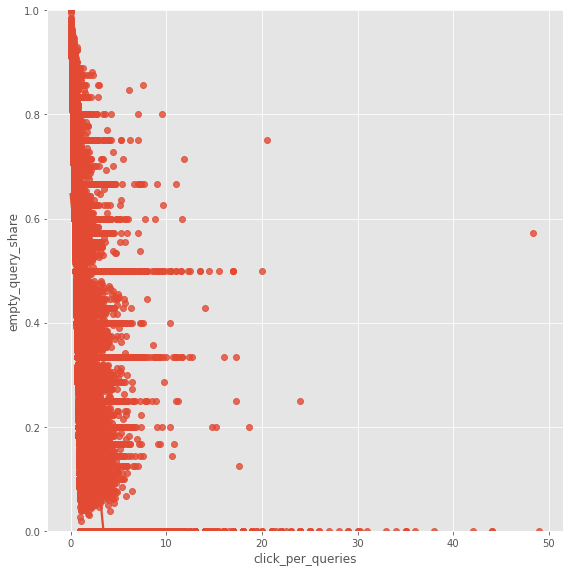

In [21]:
gr = sns.pairplot(df_after, 
                    y_vars=('empty_query_share'), 
                    x_vars=('click_per_queries'), 
                    height=8,
                    kind='reg');
gr.set(ylim=(0,1));

In [23]:
import statsmodels.formula.api as smf

model = smf.ols('click_per_queries ~ empty_query_share', data=df_after)
res = model.fit(cov_type='HC3')
df_after['covariant_y_hat'] = res.resid

model2 = smf.ols('covariant_y_hat ~ treat', data=df_after)
res_cuped = model2.fit(cov_type='HC3')

print(res_cuped.summary())

C:\Users\User\AppData\Local\Temp\ipykernel_12448\4287520012.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after['covariant_y_hat'] = res.resid


                            OLS Regression Results                            
Dep. Variable:        covariant_y_hat   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     12.51
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           0.000405
Time:                        14:30:03   Log-Likelihood:            -3.8743e+05
No. Observations:              283067   AIC:                         7.749e+05
Df Residuals:                  283065   BIC:                         7.749e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0063      0.002     -2.562      0.0

In [24]:
print(f"стандартная ошибка до CUPED: {z_std:.4f}")
print(f"стандартная ошибка после CUPED: {res_cuped.HC3_se[1]:.4f}")
print(f"ст. ошибка уменьшилась в {z_std / res_cuped.HC3_se[1]:.1f} раз")

стандартная ошибка до CUPED: 0.0044
стандартная ошибка после CUPED: 0.0036
ст. ошибка уменьшилась в 1.2 раз


*p-value в обоих случаях у переменной treat < 0.05, значит полученные коэффициенты при $d_i$ (treat) - значимые + еще и с уменьшенной дисперсией*

**Ну а вообще конечно надо делать так:** 

*ПУСТЬ click_per_queries в df_before - это $y_{t-1}$, а в df_after - это $y_t$*

*И строить регрессионную модель: $y_{t} = b_0 + w_1*y_{t-1}$*

Попробуем CUPAC. В качестве базовой модели возьмем градиентный бустинг. 

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
df_before = df.iloc[:len(df) // 2, :]
df_after = df.iloc[len(df) // 2:, :]

# x_train = pd.get_dummies(df_before.loc[:, ~df_before.columns.isin(['userID', 'slot', 'click_per_queries'])])
x_train = df_before.loc[:, ~df_before.columns.isin(['userID', 'slot', 'click_per_queries', 'browser'])]
y_train = df_before['click_per_queries']

# x_test = pd.get_dummies(df_after.loc[:, ~df_after.columns.isin(['userID', 'slot', 'click_per_queries'])])
x_test = df_after.loc[:, ~df_after.columns.isin(['userID', 'slot', 'click_per_queries', 'browser'])]
y_hat = df_after['click_per_queries']


ml_model = GradientBoostingRegressor(random_state=24)
ml_model.fit(x_train, y_train)

y_pred = ml_model.predict(x_test)

In [26]:
df_after['predicted_clicks'] = y_pred

model = smf.ols('click_per_queries ~ predicted_clicks', data=df_after)
res = model.fit(cov_type='HC3')
df_after['covariant_y_hat'] = res.resid

model2 = smf.ols('covariant_y_hat ~ treat', data=df_after)
res_cupac = model2.fit(cov_type='HC3')

print(res_cupac.summary())

C:\Users\User\AppData\Local\Temp\ipykernel_12448\2204837294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after['predicted_clicks'] = y_pred
C:\Users\User\AppData\Local\Temp\ipykernel_12448\2204837294.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after['covariant_y_hat'] = res.resid


                            OLS Regression Results                            
Dep. Variable:        covariant_y_hat   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     69.26
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           8.69e-17
Time:                        14:31:06   Log-Likelihood:             1.2503e+05
No. Observations:              283067   AIC:                        -2.501e+05
Df Residuals:                  283065   BIC:                        -2.500e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0024      0.000      6.793      0.0

In [27]:
print(f"стандартная ошибка до CUPAC: {z_std:.4f}")
print(f"стандартная ошибка после CUPAC: {res_cupac.HC3_se[1]:.4f}")
print(f"ст. ошибка уменьшилась в {z_std / res_cupac.HC3_se[1]:.1f} раз")

стандартная ошибка до CUPAC: 0.0044
стандартная ошибка после CUPAC: 0.0006
ст. ошибка уменьшилась в 7.6 раз


*Ошибка стала еще меньше!!*

*CUPAC - сильно уменьшил стандартную ошибку, однако АБ-тест он развалил, т.к. модель, в которой считалось `y_pred` никак не калибровалось. Т.е. мы предсказываем очень плохо в модели ML, поэтому эта нелинейность все портит. Если поподбирать модель и использовать не только имеющиеся данные, то потенциально CUPAC прибавит в мощности и убавит кол-во необходимых наблюдений*

*CUPED же показал, что теперь нам нужно меньше наблюдений и мощность довольно приемлимая на уровне 95%*